In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import equalize_hist
import cv2
import os
from scipy import fftpack
from skimage.transform import warp
from skimage import io
from image_registration import chi2_shift
import skimage
import image_registration
import tifffile
import time
import concurrent.futures
import skimage
import image_registration
from PIL import Image
from plantcv import plantcv as pcv
import glob

#### input: (real image directory,our whole slide image directory,two homography matrix) 
#### output:(transformation matrix that save in some directory,card_directory)

In [210]:
BR_h = np.loadtxt("/home/humangene/share/303_5/BR_h.txt")
GR_h = np.loadtxt("/home/humangene/share/303_5/GR_h.txt")
real_image_directory = "../color/"
wsi_directory = "/home/humangene/share/NEW_IR_color/"
background_directory = "/home/humangene/share/NEW_IR_color/bg/"
card_directory = "../cards/"
thread_num = 20
color_names = ["bg"]+[str(x) for x in range(1,11)]

In [2]:
def align_channel(chanel,M):
    a = skimage.transform.SimilarityTransform(matrix=M)
    return np.ma.array(warp(chanel, a, preserve_range=True,output_shape=chanel.shape, cval=-1)) 
def homography_calculator(template,moving):
    sr = StackReg(StackReg.AFFINE)
    moving_homography = sr.register(template,moving)
    return moving_homography

def generateCoefficents():
    base_folder = background_directory
    R = (cv2.imread(base_folder+"_cR.tif",cv2.IMREAD_UNCHANGED)[:,:-10])
    G = (cv2.imread(base_folder+"_cG.tif",cv2.IMREAD_UNCHANGED)[:,:-10])
    B = (cv2.imread(base_folder+"_cB.tif",cv2.IMREAD_UNCHANGED)[:,:-10])
    coeficients = []
    ref_mean = 50000
    coeficients.append((1/np.mean(R,axis=0))*ref_mean)
    coeficients.append((1/np.mean(G,axis=0))*ref_mean)
    coeficients.append((1/np.mean(B,axis=0))*ref_mean)
    return coeficients

def clipper(channel):
    a = np.quantile(channel,0.01)
    b = np.quantile(channel,0.99)
    return np.clip(channel,a,b)
def rescale(channel):
    return channel*(255.0/pow(2,16)) 

BR_h = np.loadtxt("/home/humangene/share/303_5/"+"BR_h.txt")
GR_h = np.loadtxt("/home/humangene/share/303_5/"+"GR_h.txt")

In [190]:
print("processing wsi colors:")
color_means = {}
for color in color_names:
    print(color)
    t1 = time.perf_counter()
    base_folder = wsi_directory+color+"/"
    if not(color == "bg"):
        t1 = time.perf_counter()
        num_lines = len(glob.glob(base_folder+"*.tif"))//3
        coefs = generateCoefficents()
        images = {}
        img_nums = list(range(num_lines))
        coefs = generateCoefficents()
        def reading_images(img_num):
            print(img_num)
            R = clipper(cv2.imread(base_folder+"line_"+str(img_num)+"_c1.tif",cv2.IMREAD_UNCHANGED)[:,:-10])
            G = clipper(cv2.imread(base_folder+"line_"+str(img_num)+"_c2.tif",cv2.IMREAD_UNCHANGED)[:,:-10])
            B = clipper(cv2.imread(base_folder+"line_"+str(img_num)+"_c3.tif",cv2.IMREAD_UNCHANGED)[:,:-10])
            R_e = rescale(R*coefs[0])
            G_e = align_channel(rescale(G*coefs[1]),GR_h)
            B_e = align_channel(rescale(B*coefs[2]),BR_h)
            images[img_num] =np.clip(
                 cv2.merge([
                 (R_e/np.mean(R_e,axis=0))*np.mean(R_e),
                 (G_e/np.mean(G_e,axis=0))*np.mean(G_e),
                 (B_e/np.mean(B_e,axis=0))*np.mean(B_e)
                ]),0,255).astype("uint8")[5:-5,5:-10]

            del(R)
            del(G)
            del(B)
            del(R_e)
            del(G_e)
            del(B_e)
            gc.collect()
            return img_num
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
            results = executor.map(reading_images,img_nums)
        concurrent.futures.as_completed(results)
        
        line_shifts = {}
        img_nums = list(range(num_lines-1))
        def process_image(img_num):
            print(img_num)
            right_image = images[img_num]
            left_image = images[img_num+1]
            min_row = min(right_image.shape[0],left_image.shape[0])
            min_col = min(right_image.shape[1],left_image.shape[1])
            right_image_c = right_image[:min_row,:300]
            left_image_c = left_image[:min_row,-300:]
            im1 = cv2.cvtColor(left_image_c, cv2.COLOR_BGR2GRAY)
            im2 = cv2.cvtColor(right_image_c, cv2.COLOR_BGR2GRAY)
            yoff,xoff ,yer,xer= image_registration.chi2_shift(im1,im2,0.1)
            print(yoff,xoff)
            if yoff > 30  and xoff<0:  
                line_shifts[(img_num,img_num+1)] = (int(yoff),int(-1*xoff))
        with concurrent.futures.ThreadPoolExecutor(max_workers = 20) as executor:
            results = list(executor.map(process_image,img_nums))
        concurrent.futures.as_completed(results)
        
        if len(line_shifts.keys())>0:  
            ysum = 0
            xsum = 0
            for key in line_shifts.keys():
                ysum+=line_shifts[key][0]
                xsum+=line_shifts[key][1]
            y_m = ysum//len(line_shifts.keys())
            x_m = xsum//len(line_shifts.keys())
            for i in range(num_lines - 1):
                if not((i,i+1) in line_shifts.keys()):
                    line_shifts[(i,i+1)] = (y_m,x_m)
        else:
            for i in range(num_lines - 1):
                line_shifts[(i,i+1)] = (0,0)
        sum_x = 0
        sum_y = 0
        for key , value in line_shifts.items():
            sum_x+=value[1]
            sum_y+=value[0]               
                
        valid_list = []
        for key , value in line_shifts.items():
            valid_list.append(key[1])
        yoff_sum = 0
        xoff_sum = 0
        tempelate = images[0]
        max_tot_row = tempelate.shape[0]
        max_tot_col = tempelate.shape[1]
        for val in line_shifts.values():
            yoff_sum+=val[0]
            xoff_sum+=val[1]
        img_shape = (max_tot_row,max_tot_col,3)
        mid = (int(img_shape[0]/2),int(img_shape[1]/2))
        row_numbers = img_shape[0]
        tot = np.zeros((row_numbers+xoff_sum,img_shape[1]*num_lines - yoff_sum,3),dtype = np.uint8)
        last_row_index = tot.shape[0]
        last_col_index = tot.shape[1] 
        valid_range = [last_row_index,last_row_index]
        for i in range(num_lines):
            indx = num_lines - i-1
            print(indx)
            if i in valid_list:
                middle_img = images[i]
                img_shape = (middle_img.shape[0],middle_img.shape[1],3)
                row_numbers = middle_img.shape[0]
                yshift,xshift = line_shifts[(i - 1,i)]
                tot[last_row_index-row_numbers - xshift:last_row_index-xshift,last_col_index-img_shape[1]+yshift:last_col_index+yshift,:] = middle_img
                valid_range[0] = last_row_index-row_numbers
                valid_range[1] = last_row_index+xshift
                last_row_index = last_row_index-xshift
                last_col_index = last_col_index-img_shape[1]+yshift
            else:
                middle_img = images[i]
                tot[last_row_index-middle_img.shape[0]:last_row_index,last_col_index-middle_img.shape[1]:last_col_index,:] = middle_img
                valid_range[0] = last_row_index-middle_img.shape[0]
                valid_range[1] = last_row_index

                last_row_index = last_row_index
                last_col_index = last_col_index - middle_img.shape[1]
        tifffile.imwrite("/home/humangene/Desktop/tt/"+color+".png",tot)
        middle = tot.shape[0]//2,tot.shape[1]//2
        color_means[color] = np.mean(tot[middle[0] - tot.shape[0]//3:middle[0]+tot.shape[0]//3, middle[1]-tot.shape[1]//3:middle[1]+tot.shape[1]//3],axis=(0,1))
    else:
        num_lines = 1
        coefs = generateCoefficents()
        images = {}
        img_nums = list(range(num_lines))
        def reading_images(img_num):
            R = cv2.imread(base_folder+"BG_cR.tif",cv2.IMREAD_UNCHANGED)[:,:-10]
            G = cv2.imread(base_folder+"BG_cG.tif",cv2.IMREAD_UNCHANGED)[:,:-10]
            B = cv2.imread(base_folder+"BG_cB.tif",cv2.IMREAD_UNCHANGED)[:,:-10]
            R_e = rescale(R*coefs[0])
            G_e = align_channel(rescale(G*coefs[1]),GR_h)
            B_e = align_channel(rescale(B*coefs[2]),BR_h)
            images[img_num] =np.clip(
                 cv2.merge([
                 (R_e/np.mean(R_e,axis=0))*np.mean(R_e),
                 (G_e/np.mean(G_e,axis=0))*np.mean(G_e),
                 (B_e/np.mean(B_e,axis=0))*np.mean(B_e)
                ]),0,255).astype("uint8")[5:-5,5:-10]

            del(R)
            del(G)
            del(B)
            del(R_e)
            del(G_e)
            del(B_e)
            gc.collect()
            return img_num
        with concurrent.futures.ThreadPoolExecutor(max_workers=thread_num) as executor:
            results = executor.map(reading_images,img_nums)
        concurrent.futures.as_completed(results)
        tot = images[0]
        middle = tot.shape[0]//2,tot.shape[1]//2
        tifffile.imwrite("/home/humangene/Desktop/tt/"+color+".png",tot)
        color_means[color] = np.mean(tot[middle[0] - tot.shape[0]//3:middle[0]+tot.shape[0]//3, middle[1]-tot.shape[1]//3:middle[1]+tot.shape[1]//3],axis=(0,1))
    t2 = time.perf_counter()
    print("time: "+str(t2 - t1))
print("processing real color:")
rcolor_means = {}
for color in color_names:
    t1 = time.perf_counter()
    tot = tifffile.imread(real_image_directory+color+".tif")
    middle = tot.shape[0]//2,tot.shape[1]//2
    rcolor_means[color] = np.mean(tot[middle[0] - tot.shape[0]//3:middle[0]+tot.shape[0]//3, middle[1]-tot.shape[1]//3:middle[1]+tot.shape[1]//3],axis=(0,1))
    t2 = time.perf_counter()
    print(t2-t1)

processing wsi colors:
bg
time: 3.8407558479811996
1
0
1
2
01



/opt/anaconda/lib/python3.9/site-packages/image_registration/fft_tools/convolve_nd.py:269: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/anaconda/lib/python3.9/site-packages/image_registration/fft_tools/convolve_nd.py:270: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/anaconda/lib/python3.9/site-packages/image_registration/fft_tools/convolve_nd.py:325: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array 

35.349609375 -15.591796875
40.021484375 -16.119140625
2
1
0
time: 5.827992095029913
2
01

2
3


KeyboardInterrupt: 

In [40]:
print("creating the cards:")
t1 = time.perf_counter()
n = len(color_names)
tile_size = 256
space = 100
row_size = n*tile_size + (n+1)*space
col_size = tile_size +space
real_card = (np.ones((row_size,col_size,3))*255).astype("uint8")
wsi_card = (np.ones((row_size,col_size,3))*255).astype("uint8")
mask = (np.zeros((row_size,col_size))).astype("uint8")
count = 0
for color in color_names:
    start_row = ((count+1)*space)+(count*tile_size)
    start_col = 50
    real_card[start_row:start_row+tile_size,start_col:start_col+tile_size,:] = rcolor_means[color]
    wsi_card[start_row:start_row+tile_size,start_col:start_col+tile_size,:] = color_means[color]
    mask[start_row:start_row+tile_size,start_col:start_col+tile_size] = count+1
    count+=1
tifffile.imwrite(card_directory+"real.png",real_card.astype("uint8"))
tifffile.imwrite(card_directory+"source.png",wsi_card.astype("uint8"))
tifffile.imwrite(card_directory+"mask.png",mask.astype("uint8"))
t2 = time.perf_counter()
print(t2 - t1)

creating the cards:
0.0753302329685539


In [212]:
real_card = tifffile.imread(card_directory+"real.png")
wsi_card = tifffile.imread(card_directory+"source.png")
mask = tifffile.imread(card_directory+"mask.png")

In [213]:
def get_color_matrix(rgb_img, mask):
    if len(np.shape(rgb_img)) != 3:
        fatal_error("Input rgb_img is not an RGB image.")
    if len(np.shape(mask)) != 2:
        fatal_error("Input mask is not an gray-scale image.")
    img_dtype = rgb_img.dtype
    max_val = 1.0
    if img_dtype.kind == 'u':
        max_val = np.iinfo(img_dtype).max
    rgb_img = rgb_img.astype(np.float64)/max_val
    color_matrix = np.zeros((len(np.unique(mask))-1, 4))
    headers = ["chip_number", "r_avg", "g_avg", "b_avg"]
    row_counter = 0
    for i in np.unique(mask):
        if i != 0:
            chip = rgb_img[np.where(mask == i)]
            color_matrix[row_counter][0] = i
            color_matrix[row_counter][1] = np.mean(chip[:, 2])
            color_matrix[row_counter][2] = np.mean(chip[:, 1])
            color_matrix[row_counter][3] = np.mean(chip[:, 0])
            row_counter += 1
    return headers, color_matrix
def get_matrix_m(target_matrix, source_matrix):
    t_cc, t_r, t_g, t_b = np.split(target_matrix, 4, 1)
    s_cc, s_r, s_g, s_b = np.split(source_matrix, 4, 1)

    # create matrix_a
    ones = np.ones_like(s_b)
    matrix_a = np.concatenate((s_r, s_g, s_b,ones), 1)
    matrix_m = np.linalg.solve(np.matmul(matrix_a.T, matrix_a), matrix_a.T)
    matrix_b = np.concatenate((t_r,t_g, t_b), 1)
    return matrix_a, matrix_m, matrix_b


def calc_transformation_matrix(matrix_m, matrix_b):
    t_r, t_g, t_b = np.split(matrix_b, 3, 1)

    # multiply each 22x1 matrix from target color space by matrix_m
    transformation_matrix = np.matmul(matrix_m, matrix_b)
    return transformation_matrix

def apply_transformation_matrix(source_img, transformation_matrix):

    red, green, blue = np.split(transformation_matrix, 3, 1)
    source_dtype = source_img.dtype
    # normalization value as max number if the type is unsigned int
    max_val = 1.0
    if source_dtype.kind == 'u':
        max_val = np.iinfo(source_dtype).max
    # convert img to float to avoid integer overflow, normalize between 0-1
    source_flt = source_img.astype(np.float64)/max_val
    # find linear, square, and cubic values of source_img color channels
    source_b, source_g, source_r = cv2.split(source_flt)

    # apply linear model to source color channels
    b = blue[3] + source_r * blue[0] + source_g * blue[1] + source_b * blue[2] 
    g = green[3] + source_r * green[0] + source_g * green[1] + source_b * green[2] 
    r = red[3] + source_r * red[0] + source_g * red[1] + source_b * red[2] 

    # merge corrected color channels onto source_image
    bgr = [b, g, r]
    corrected_img = cv2.merge(bgr)

    # return values of the image to the original range
    corrected_img = max_val*np.clip(corrected_img, 0, 1)
    # cast back to original dtype (if uint the value defaults to the closest smaller integer)
    corrected_img = corrected_img.astype(source_dtype)
    return corrected_img


In [214]:
target_headers, target_matrix = get_color_matrix(real_card, mask)
source_headers, source_matrix = get_color_matrix(wsi_card, mask)

In [215]:
matrix_a, matrix_m, matrix_b = get_matrix_m(target_matrix=target_matrix, source_matrix=source_matrix)


In [216]:
transformation_matrix = calc_transformation_matrix(matrix_m, matrix_b)

In [217]:
transformation_matrix

array([[ 3.00259608,  0.11769524, -0.36696199],
       [-1.64682845,  1.73414747,  0.03247072],
       [-0.08895442, -0.62108925,  1.80938696],
       [-0.01116838,  0.16752787, -0.15381074]])

In [218]:
corrected = apply_transformation_matrix(wsi_card,transformation_matrix)

In [219]:
tifffile.imwrite("../corrected_card3",corrected)

In [247]:
tot = tifffile.imread("/home/humangene/Desktop/images_7.png")

In [248]:
# R = tot[:,:,2]
# G = tot[:,:,1]
# B = tot[:,:,0]
# tot = cv2.merge([R,G,B])

In [249]:
middle = tot.shape[0]//2,tot.shape[1]//2
s = 6000
test_img = tot[middle[0] - s:middle[0]+s , middle[1]-s:middle[1]+s]

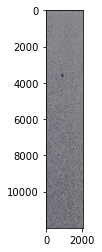

In [250]:
plt.imshow(test_img)

In [251]:
corrected = apply_transformation_matrix(tot,transformation_matrix)

In [252]:
R = corrected[:,:,0]
G = corrected[:,:,1]
B = corrected[:,:,2]

In [253]:
img2 = np.clip(cv2.merge([R*1.385869565,G*1.138392857,B*1.220095694]),0,255).astype("uint8")

In [254]:
R2 = img2[:,:,0]
G2 = img2[:,:,1]
B2 = img2[:,:,2]

In [255]:
tifffile.imwrite("../images_7.png",img2)

In [116]:
def show_col_dis(R,G,B):
    plt.plot(np.mean(R,axis=0),color = "red")
    plt.plot(np.mean(G,axis=0),color = "green")
    plt.plot(np.mean(B,axis=0),color = "blue")


In [147]:

R2_e = (R2/np.mean(R2,axis=0)) *np.mean(R2)
G2_e = (G2/np.mean(G2,axis=0)) *np.mean(G2)
B2_e = (B2/np.mean(B2,axis=0)) *np.mean(B2)

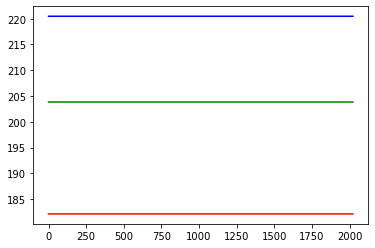

In [148]:
show_col_dis(R2_e,G2_e,B2_e)

In [151]:
cv2.imwrite("../fff.png",np.clip(cv2.merge([B2_e,G2_e,R2_e]),0,255).astype("uint8"))

True

In [80]:
(B*1.0569274286636272).shape

(8182, 2023)

In [87]:
cv2.merge([R*(1.03),G*4,B*5])

error: OpenCV(4.6.0) /io/opencv/modules/core/src/merge.dispatch.cpp:129: error: (-215:Assertion failed) mv[i].size == mv[0].size && mv[i].depth() == depth in function 'merge'
